<a href="https://colab.research.google.com/github/Xiao-Yu-Cassie/Speech-Emotion-Recognition-on-Iemocap/blob/main/707proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Check Hardware Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May  7 18:11:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install -U torchtext==0.8.0
!pip install transformers

     |████████████████████████████████| 7.0MB 5.2MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1
     |████████████████████████████████| 2.1MB 6.3MB/s 
     |████████████████████████████████| 901kB 21.7MB/s 
     |████████████████████████████████| 3.3MB 35.3MB/s 


#Environment Setup

In [ ]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from IPython.core.display import Image, display
from torchvision.utils import save_image
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy
import pickle
#from bert_embedding import BertEmbedding


In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

cuda


#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Single-Utterance-based LSTM with Attention

In [ ]:
import torch.nn as nn
class LSTM_Classifer(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, class_num, dropout=0.5):
    super().__init__()
    self.class_num = class_num
    self.dropout = dropout
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim)
    self.output_dim = output_dim
   
    self.fc1 = nn.Linear(self.hidden_dim, output_dim)
    self.act1 = nn.ReLU()
    self.output_layer = nn.Linear(output_dim, class_num)
    self.dropoutLayer = nn.Dropout(self.dropout)

  def attention(self, lstm_out, inp):
    permuted_output = lstm_out.permute(1, 0, 2) #(batch, seqlen, hidden)
    inp = torch.squeeze(inp, 0) #size (batch, hidden_size)
    inp_tmp = torch.unsqueeze(inp, 2)
    attn_weights = torch.bmm(permuted_output, inp_tmp) # (batch, seqlen, 1)
    attn_weights = torch.squeeze(attn_weights, 2) # (batch, seqlen)
    softmax_weights = F.softmax(attn_weights, 1) # (batch, seqlen)
    softmax_weights = torch.unsqueeze(softmax_weights, 2) #(batch, seqlen, 1)
    new_hidden_state = torch.bmm(permuted_output.transpose(1, 2), softmax_weights)
    new_hidden_state = torch.squeeze(new_hidden_state, 2) #(batch, hidden)
    return new_hidden_state


  def forward(self, x):
    batch_size = x.shape[1]
    lstm_out, (hidden, c) = self.lstm(x)
    attn_output = self.attention(lstm_out, hidden)
    output = self.fc1(attn_output)
    output = self.act1(output)
    output = self.output_layer(output)
    return output

  def encode_feature(self, x):
    batch_size = x.shape[1]
    lstm_out, (hidden, c) = self.lstm(x)
    attn_output = self.attention(lstm_out, hidden)
    return attn_output



#torchtext Preprocessing

In [ ]:
pip install numpy --upgrade

     |████████████████████████████████| 15.3MB 350kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:
import numpy
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
torch.__version__

'1.8.1+cu101'

In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator, LabelField

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)


512


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

#Text and Audio Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import pickle
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text = "Nick likes to play football, however he is not too fond of tennis."
text_tokens = word_tokenize(text)
tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
print(tokens_without_sw)

# From Poria's official code https://github.com/soujanyaporia/multimodal-sentiment-analysis/blob/master/dataset/iemocap/raw/IEMOCAP_features_raw.pkl.zip
videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = pickle.load(open("gdrive/MyDrive/IEMOCAP_features_raw.pkl", "rb"), encoding='latin1')

#train_size: 120 videos.  test_size: 31 videos


def generate_tokens(sentence):
  sentence = sentence.lower()
  sentence = sentence.translate(str.maketrans("","", string.punctuation))
  sentence = sentence.strip()
  sentence_tokenize = word_tokenize(sentence)
  sentence_no_stopwords = [word for word in sentence_tokenize if not word in stopwords.words()]
  res = sentence_no_stopwords
  res = [lemmatizer.lemmatize(word) for word in res]
  res = ['[CLS]'] + res + ['[SEP]']
  return res

#padding + bertembeded
def bert_embed(tokens, max_len):
  padded_tokens = tokens + ['[PAD]' for _ in range(max_len-len(tokens))]
  attn_mask = [ 1 if token != '[PAD]' else 0 for token in padded_tokens]
  seg_ids=[0 for _ in range(len(padded_tokens))]
  sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
  token_ids = torch.tensor(sent_ids).unsqueeze(0) 
  attn_mask = torch.tensor(attn_mask).unsqueeze(0) 
  seg_ids  = torch.tensor(seg_ids).unsqueeze(0)
  output = bert_model(token_ids, attention_mask = attn_mask,token_type_ids = seg_ids)

  attn_mask = attn_mask.float()


  return (output.last_hidden_state)[0] , attn_mask


def get_iemocap_raw():
    train_text = []
    train_seq_len = []
    train_label = []

    test_text = []
    test_seq_len = []
    test_label = []

    for vid in trainVid:
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          sentence_tokens = generate_tokens(cur_sentence)
          train_text.append(sentence_tokens)
          train_label.append(cur_label)
    
    for vid in testVid:
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          sentence_tokens = generate_tokens(cur_sentence)
          test_text.append(sentence_tokens)
          test_label.append(cur_label)
    
    return train_text, train_label, test_text, test_label


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['Nick', 'likes', 'play', 'football', ',', 'however', 'fond', 'tennis', '.']


In [ ]:
train_text, train_label, test_text, test_label = get_iemocap_raw()

In [ ]:
#Audio loading
Audio_file =  pickle.load(open("gdrive/MyDrive/audio.pickle", "rb"), encoding='latin1')
def load_audio_raw():
  train_wav = []
  train_sample_rate = []
  train_activation = []
  train_valence = []
  train_dominance = []
  train_label = []


  test_wav = []
  test_sample_rate = []
  test_activation = []
  test_valence = []
  test_dominance = []
  test_label = []

  for vid in trainVid:
    for key in Audio_file[vid].keys():
      cur_wav = Audio_file[vid][key]['waveform']
      cur_sample_rate = Audio_file[vid][key]['sample_rate']
      cur_emotion = Audio_file[vid][key]['emotion']
      cur_activation = Audio_file[vid][key]['activation']
      cur_valence = Audio_file[vid][key]['valence']
      cur_dominance = Audio_file[vid][key]['dominance']

      train_wav.append(cur_wav)
      train_sample_rate.append(cur_sample_rate)
      train_activation.append(cur_activation)
      train_valence.append(cur_valence)
      train_dominance.append(cur_dominance)

      train_label.append(cur_emotion)
    
  for vid in testVid:
    for key in Audio_file[vid].keys():
      cur_wav = Audio_file[vid][key]['waveform']
      cur_sample_rate = Audio_file[vid][key]['sample_rate']
      cur_emotion = Audio_file[vid][key]['emotion']
      cur_activation = Audio_file[vid][key]['activation']
      cur_valence = Audio_file[vid][key]['valence']
      cur_dominance = Audio_file[vid][key]['dominance']

      test_wav.append(cur_wav)
      test_sample_rate.append(cur_sample_rate)
      test_activation.append(cur_activation)
      test_valence.append(cur_valence)
      test_dominance.append(cur_dominance)

      test_label.append(cur_emotion)
  
  train_info = {
      'wav': train_wav,
      'sample_rate': train_sample_rate,
      'activation': train_activation,
      'dominance': train_dominance,
      'valence': train_valence,
      'label': train_label
  }

  test_info = {
      'wav': test_wav,
      'sample_rate': test_sample_rate,
      'activation': test_activation,
      'dominance': test_dominance,
      'valence': test_valence,
      'label': test_label
  }


    
  return train_info, test_info

In [ ]:
train_audio_info, test_audio_info = load_audio_raw()

#Raw Text Dataset Class 

In [ ]:
class TextRaw_dataset(Dataset):
    def __init__(self, tokens, labels, max_len):
        self.data = tokens
        self.labels = labels
        self.max_len = max_len
    def __getitem__(self, idx):
        text_tokens = self.data[idx]
        label = [float(self.labels[idx])]
        embeded, mask = bert_embed(text_tokens, self.max_len)
        mask = torch.Tensor(mask).float()
        label = torch.Tensor(label).float()


        embeded_no_grad = embeded.detach()
        mask.requires_grad = False
        label.requires_grad = False
        
        return (embeded_no_grad, mask, label)
        
    def __len__(self):
        return len(self.data)

# Train-text modality


In [ ]:
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
%matplotlib inline

class TrainRaw():
  def __init__(self):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(self.device)
    self.max_len = 49
    self.batch_size = 35
    self.plot_every = 83 # plot the avg loss of 8 batches

    #get iemocap text data
    self.train_text, self.train_label, self.test_text, self.test_label = train_text, train_label, test_text, test_label # get_iemocap_raw()
    self.trainRaw = TextRaw_dataset(self.train_text, self.train_label, self.max_len)
    self.testRaw = TextRaw_dataset(self.test_text, self.test_label, self.max_len)

    self.dataloader1 = DataLoader(self.trainRaw, batch_size=self.batch_size, shuffle=True, num_workers=4)
    self.dataloader2 = DataLoader(self.testRaw, batch_size=self.batch_size, shuffle=True, num_workers=4)
    
    self.net = LSTM_Classifer(input_dim=768, hidden_dim=100, output_dim=100, class_num=6).to(self.device)

    self.plot_train_losses = []
    self.plot_test_losses = []
    self.test_acc_l = []
    self.train_acc_l = []

    self.best_acc = 0
    self.train()

   

  def train(self):
    EPOCHS = 20
    self.optimizer = optim.Adam(self.net.parameters(), lr=0.0001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.75, patience=2, verbose=True)
    self.loss_function = nn.CrossEntropyLoss()
    self.test_loss()
    for epoch in range(EPOCHS):
      batch_index = 1
      loss_sum = 0
      correct_cnt = 0
      for  X, mask, label in tqdm(self.dataloader1):
        self.optimizer.zero_grad()
        batch_index += 1
        X = X.permute([1, 0, 2])
        X = X.to(self.device)
        label = label.long().to(self.device)
        label = label.reshape(self.batch_size)
        output = self.net(X) 
        loss = self.loss_function(output, label)     
        loss_sum += loss.item()

        # save for train acc
        pred = torch.max(output, axis=1).indices      
        eq = torch.eq(label, pred)     
        correct_cnt += torch.sum(eq)

        # calculate loss and accuracy
        if (batch_index % self.plot_every == 0):
          avg_loss = loss_sum / (self.plot_every * self.batch_size)
          #print(avg_loss)
          self.plot_train_losses.append(avg_loss)
          loss_sum = 0

          test_loss, test_acc = self.test_loss()
          self.plot_test_losses.append(test_loss)
          self.test_acc_l.append(test_acc)

          train_acc = float(correct_cnt / (self.plot_every * self.batch_size))
          correct_cnt = 0
          self.train_acc_l.append(train_acc)

          print(f"Epoch: {epoch}. Train Loss: {avg_loss}. Train Acc: {train_acc}. Test Loss: {test_loss}. Test Acc: {test_acc}")
          self.plot(self.plot_train_losses, self.plot_test_losses, "train_loss", "validation_loss")
          self.plot(self.train_acc_l, self.test_acc_l, "train_acc", "validation_acc")


        loss.backward()
        self.optimizer.step()

      #self.plot()
      # train_loss = float(loss_sum / batch_index)
      # self.plot_train_losses.append(train_loss)
      #print(f"Epoch: {epoch}. Loss: {train_loss}")
      # test_loss = self.test_loss()
      self.scheduler.step(test_loss)
      # self.plot_test_losses.append(test_loss)

    # self.test_loss()
  
  
  
  def test_loss(self):
    with torch.no_grad():
      loss_sum = 0
      batch_index = 0
      correct_cnt = 0
      for X, mask, label in self.dataloader2:
        batch_index += 1
        X = X.permute([1, 0, 2])
        X = X.to(self.device)
        label = label.long().to(self.device)
        if (len(label)) < self.batch_size:
          continue
        label = label.reshape(self.batch_size)
        output = self.net(X)
        loss = self.loss_function(output, label)
        loss_sum += loss.item()

        pred = torch.max(output, axis=1).indices      
        eq = torch.eq(label, pred)
        # print("pred", pred)     
        # print("label", label)
        correct_cnt += torch.sum(eq)
      

    avg_loss = loss_sum / (batch_index * self.batch_size)
    # print("denom", batch_index * self.batch_size)
    # print("num", correct_cnt * self.batch_size)
    acc = float(correct_cnt/ (batch_index * self.batch_size))
    #print("acc:", acc)
    return avg_loss, acc
    
  def plot(self, l1, l2, label1, label2):
    plt.plot(l1, 'b', label=label1)
    plt.plot(l2, 'g', label=label2)
    plt.legend()
    plt.show()



#T = TrainRaw()

In [ ]:
trained_text_model = TrainRaw()

In [ ]:
saved_text_model = {
    'train_epochs': 20,
    'model': trained_text_model.net.state_dict(),
    'optimizer': trained_text_model.optimizer.state_dict(),
    'criterion': trained_text_model.loss_function.state_dict(),
    'scheduler': trained_text_model.scheduler.state_dict(),
    'plot_train_losses': trained_text_model.plot_train_losses,
    'plot_test_losses': trained_text_model.plot_test_losses,
    'test_acc_l': trained_text_model.test_acc_l,
    'train_acc_l':  trained_text_model.train_acc_l
}

torch.save(saved_text_model, 'gdrive/MyDrive/complete_model{}'.format(20))

In [ ]:
checkpoint = torch.load('gdrive/MyDrive/complete_model{}')
trained_text_model = LSTM_Classifer(input_dim=768, hidden_dim=100, output_dim=100, class_num=6).to(device)
trained_text_model.load_state_dict(checkpoint['model'])
trained_text_model.eval()

LSTM_Classifer(
  (lstm): LSTM(768, 100)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (act1): ReLU()
  (output_layer): Linear(in_features=100, out_features=6, bias=True)
  (dropoutLayer): Dropout(p=0.5, inplace=False)
)

# Audio Dataset


In [ ]:
# path
# waveform
# sample_rate
# emotion
# activation
# valence
# dominance
audio_d = pickle.load(open("gdrive/MyDrive/audio.pickle", "rb"), encoding='latin1')

In [ ]:
class Iemocap_audio_dataset(object):

  #Vids is either trainVid or testVid
  def __init__(self, Vids):
      self.audio_data = []
      for vid in Vids:
        for utt in videoIDs[vid]:
          cur_utt = audio_d[vid][utt]

          sample = {
            'path': cur_utt['path'],
            'waveform': torch.tensor(cur_utt['waveform']),
            'sample_rate': cur_utt['sample_rate'],
            'emotion': cur_utt['emotion'],
            'activation': cur_utt['activation'],
            'valence': cur_utt['valence'],
            'dominance': cur_utt['dominance']
          }
          self.audio_data.append(sample)
  
  def __len__(self):
    return len(self.audio_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.audio_data[idx]
    




In [ ]:
# train_audio =  Iemocap_audio_dataset(trainVid)
# test_audio =  Iemocap_audio_dataset(testVid)
# print(len(audio_train))

In [ ]:
# iemocap_dataset = train_audio
# def f():
#     cnt = 0
#     for i in range(len(iemocap_dataset)):
#         sample = iemocap_dataset[i]
#         print(type(sample))
#         print(i, sample)
#         cnt += 1
#         if cnt > 1:
#             return
# f()


<class 'dict'>
0 {'path': '/home/yudong/Private/datasets/IEMOCAP/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav', 'waveform': tensor([[-0.0050, -0.0050, -0.0038,  ..., -0.0027, -0.0032, -0.0042]]), 'sample_rate': 16000, 'emotion': 2.0, 'activation': 2.5, 'valence': 2.5, 'dominance': 2.5}
<class 'dict'>
1 {'path': '/home/yudong/Private/datasets/IEMOCAP/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M000.wav', 'waveform': tensor([[-0.0035, -0.0031, -0.0063,  ...,  0.0034,  0.0027,  0.0026]]), 'sample_rate': 16000, 'emotion': 5.0, 'activation': 2.5, 'valence': 2.0, 'dominance': 2.5}


In [ ]:
def collage_fn_vgg(batch):
        # Clip or pad each utterance audio into 4.020 seconds.
        sample_rate = 16000
        n_channels = 1
        frame_length = int(4.020 * sample_rate)

        # Initialize output
        waveforms = torch.zeros(0, n_channels, frame_length)
        emotions = torch.zeros(0)

        for item in batch:
            waveform = item['waveform']
            original_waveform_length = waveform.shape[1]
            padded_waveform = F.pad(waveform, (0, frame_length - original_waveform_length)) if original_waveform_length < frame_length else waveform[:, :frame_length]
            waveforms = torch.cat((waveforms, padded_waveform.unsqueeze(0)))
            emotions = torch.cat((emotions, torch.tensor([item['emotion']])), 0)

        return waveforms, emotions

# Train audio modality

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:        1 x 64240 --> 64 x 200
        self.conv1a = nn.Conv1d(1, 64, kernel_size=400, stride=160)
        self.conv1b = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)

        # block 2:          64 x 200 --> 128 x 50
        self.conv2a = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(4)

        # block 3:          128 x 50 --> 256 x 12
        self.conv3a = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(4)

        # block 4:          256 x 12 --> 512 x 4
        self.conv4a = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(3)

        # linear layers:    512 x 4 --> 2048 --> 4096 --> 4096 --> 9
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 100)
        self.linear4 = nn.Linear(100, 6)

    def forward(self, x, get_embed=False):

        # block 1
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        # block 4:
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        if get_embed:
          return x
        x = self.linear4(x)

        return x
    


In [ ]:
audio_d = pickle.load(open("gdrive/MyDrive/audio.pickle", "rb"), encoding='latin1')
audio_trainset =  Iemocap_audio_dataset(trainVid)
audio_testset =  Iemocap_audio_dataset(testVid)

In [ ]:
import copy
from torch.optim import lr_scheduler
class Train_audio():
  def __init__(self):
    self.audio_trainset = audio_trainset
    self.audio_testset = audio_testset
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(self.device)
    self.batch_size = 35
    self.EPOCHS = 10

    self.train_loss_l = []
    self.test_loss_l = []

    self.train_acc_l = []
    self.test_acc_l = []


    # self.dataloader1 = DataLoader(self.audio_trainset, batch_size=self.batch_size, shuffle=True, num_workers=4)
    # self.dataloader2 = DataLoader(self.audio_testset, batch_size=self.batch_size, shuffle=True, num_workers=4)
    datasets = {
    'train': self.audio_trainset,
    'val': self.audio_testset }

    dataset_sizes = { x: len(datasets[x]) for x in ['train', 'val'] }
    self.dataloaders = { x: torch.utils.data.DataLoader(datasets[x], batch_size=self.batch_size, shuffle=True, num_workers=4, collate_fn=collage_fn_vgg) for x in ['train', 'val'] }
    self.dataset_sizes = { x: len(datasets[x]) for x in ['train', 'val'] }
    self.model = VGG_convnet().to(self.device)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer_ft = optim.Adam(self.model.parameters(), lr=0.001)
    self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer_ft, step_size=7, gamma=0.1)
    self.model = self.train(self.model, self.criterion, self.optimizer_ft,  self.exp_lr_scheduler, self.EPOCHS)
    self.datasets = datasets


  
  def train(self, model, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in self.dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / self.dataset_sizes[phase]
            epoch_acc = running_corrects.double() / self.dataset_sizes[phase]

            if phase == 'train':
              self.train_loss_l.append(epoch_loss)
              self.train_acc_l.append(epoch_acc)
            
            else:
              self.test_loss_l.append(epoch_loss)
              self.test_acc_l.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    self.plot(self.train_loss_l, self.test_loss_l, "train_loss", "validation_loss")
    self.plot(self.train_acc_l, self.test_acc_l, "train_acc", "validation_acc")


    #time_elapsed = time.time() - since
    #print('raining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
  

  def get_embed(self):
    dataloaders = { x: torch.utils.data.DataLoader(self.datasets[x], batch_size=35, shuffle=False, num_workers=4, collate_fn=collage_fn_vgg) for x in ['train', 'val'] }
    d = dict()
    with torch.no_grad():
      for phase in ['train', 'val']:
        d[phase] = []
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.long().to(device)
          outputs = self.model(inputs, get_embed=True)
          d[phase].append(outputs)
        d[phase] = torch.cat(d[phase], dim=0)
    return d


  def plot(self, l1, l2, label1, label2):
    plt.plot(l1, 'b', label=label1)
    plt.plot(l2, 'g', label=label2)
    plt.legend()
    plt.show()
    
    


In [ ]:
# d = train.get_embed()

In [ ]:
# tr = d['train']
# print(np.shape(tr))

torch.Size([5810, 100])


In [ ]:
# print(np.shape(tr[0]))

torch.Size([100])


cuda:0
Epoch 0/9
train Loss: 1.7430 Acc: 0.2361
val Loss: 1.7489 Acc: 0.2292
Epoch 1/9
train Loss: 1.6411 Acc: 0.2928
val Loss: 1.6036 Acc: 0.2951
Epoch 2/9
train Loss: 1.5412 Acc: 0.3552
val Loss: 1.5675 Acc: 0.3580
Epoch 3/9
train Loss: 1.5187 Acc: 0.3747
val Loss: 1.5725 Acc: 0.3420
Epoch 4/9
train Loss: 1.4934 Acc: 0.3842
val Loss: 1.5743 Acc: 0.3623
Epoch 5/9
train Loss: 1.4863 Acc: 0.3960
val Loss: 1.5752 Acc: 0.3426
Epoch 6/9
train Loss: 1.4674 Acc: 0.4040
val Loss: 1.6360 Acc: 0.3715
Epoch 7/9
train Loss: 1.4181 Acc: 0.4182
val Loss: 1.5549 Acc: 0.3715
Epoch 8/9
train Loss: 1.3961 Acc: 0.4301
val Loss: 1.5575 Acc: 0.3580
Epoch 9/9
train Loss: 1.3842 Acc: 0.4349
val Loss: 1.5618 Acc: 0.3604


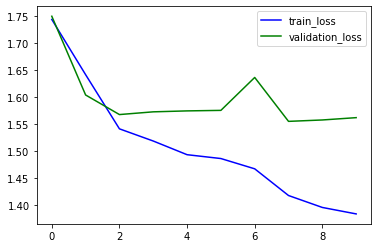

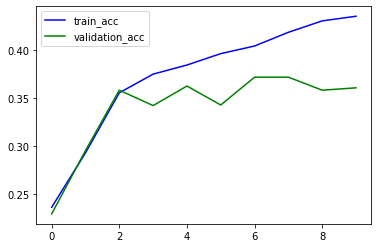

Best val Acc: 0.371534


In [ ]:
trained_audio_model = Train_audio()

#LSTM Utterance

In [ ]:
class LSTM_Utter(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_classes, dropout = 0.5):
    super(LSTM_Utter, self ).__init__() 
    self.num_classes = num_classes
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.dropout_rate = dropout
    self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = 2, bidirectional = True, dropout=dropout)
    self.actattn = nn.ReLU()
    self.attn_dim = 2 * hidden_dim
    self.attentionfc = nn.Linear(self.attn_dim, self.attn_dim)

    # enter linear classifier after exiting from attention
    self.fc1 = nn.Linear(self.attn_dim, 100)
    self.act1 = nn.ReLU()
    self.output_layer = nn.Linear(100, self.num_classes)
    self.dropout_layer = nn.Dropout(dropout)

  def attention(self, x_encode, x_lstmout, mask):
    # assert(output)
    # x_encode => (batch, hidden)
    # M => (seqlen, batch, output)
    # mask => (batch, seqlen)
    # print("x_encode",np.shape(x_encode))
    # print("x_lstmout", np.shape(x_lstmout))
    # print("mask",np.shape(mask))
    mask_seq = mask.unsqueeze(2)
    mask_seq = mask_seq.repeat(1, 1, self.attn_dim) #mask_seq => (batch, seqlen, output)
    transposed_seq = x_lstmout.transpose(0, 1) #transposed_seq => (batch, seqlen, output)
    masked_output = transposed_seq * mask_seq #masked_output => (batch, seqlen, output)

    x_hidden = self.attentionfc(x_encode)
    x_hidden = torch.unsqueeze(x_hidden, 1)  #x_hidden => (batch, 1, output) 

    attn = torch.bmm(x_hidden, masked_output.transpose(1, 2)) #attn => (batch, 1, seqlen)
    masked_attn = torch.tanh(attn * torch.unsqueeze(mask, 1)) #attn => (batch, 1, seqlen)
    normalized_attn = F.softmax(masked_attn, dim=2) #normalized_attn => (batch, 1, seqlen)

    attn_sum = torch.sum(normalized_attn * torch.unsqueeze(mask, 1), dim=2, keepdim=True) # batch, 1, 1
    normalized_attn = normalized_attn / attn_sum  # batch, 1, seqlen ; normalized
    attn_pool = torch.bmm(normalized_attn, transposed_seq) # batch, 1, output
    return attn_pool[:,0,:]

  def forward(self, x, mask):
    x_lstmout, (hidden_res,c) = self.lstm(x)
    attention_info = []

    for x_encode in x_lstmout:
      attn_pool = self.attention(x_encode, x_lstmout, mask)
      attn_pool = torch.unsqueeze(attn_pool, 0)
      attention_info.append(attn_pool)

    attn_res  = torch.cat(attention_info,dim=0) # => seqlen, batch, output
    res = self.fc1(attn_res)
    res = self.act1(res)
    res = self.dropout_layer(res)
    out = self.output_layer(res) # => (seqlen, batch, 6) 
    return out

# Utterance: data preprocessing



*   train_text -> encoder -> train_encoded

*   test_text -> encoder -> test_encoded


In [ ]:
embed_audio_train = trained_audio_model.get_embed()['train'].detach().to('cpu')
embed_audio_test = trained_audio_model.get_embed()['val'].detach().to('cpu')

In [ ]:
def utterances_padding(x, max_utterance_len):
  assert(len(x.shape) == 2)
  encoded_dim = x.shape[1]
  seqlen = x.shape[0]
  padding = torch.zeros(max_utterance_len - seqlen, encoded_dim).float()
  padded_res = np.concatenate((x, padding))
  seqlen = x.shape[0]
  mask = torch.zeros(max_utterance_len, encoded_dim).float()
  mask[0:seqlen, :] = 1.0
  return padded_res, mask

def label_padding(label, max_utterance_len):
  seqlen = label.shape[0]
  padding = torch.zeros(max_utterance_len - seqlen).float()
  padded_res = np.concatenate((label, padding))

  mask = torch.zeros(max_utterance_len).float()
  mask[0:seqlen] = 1.0
  return padded_res, mask


(utterance_count, max_sentence_len, 768) => encode => (utterances_count, hidden_size)
def get_iemocap_encoded(model, sentence_max_len):
  #model should be pretrained LSTM_Classifier type 
  #sentence_max_len <=> model
  train_video = []
  train_video_label = []
  test_video = []
  test_video_label = []

  # embed_audio_train = train.get_embed()['train'].detach().to('cpu')
  # embed_audio_test = train.get_embed()['val'].detach().to('cpu')
  # cnt = 0
  idx = -1
  for vid in trainVid:
    # cnt += 1
    # if (cnt > 2):
    #   break
    vid_sentences = []
    vid_audio = []
    vid_labels = videoLabels[vid]
    vid_labels = torch.Tensor(vid_labels).float()
    vid_labels.requires_grad = False
    for i in range(len(videoSentence[vid])):
      idx += 1

      cur_sentence = videoSentence[vid][i]
      sentence_tokens = generate_tokens(cur_sentence)
      embeded, mask = bert_embed(sentence_tokens, sentence_max_len)
      mask = torch.Tensor(mask).float()

      embeded_no_grad = embeded.detach() #=> (max_sentence_len, 768) 
      mask.requires_grad = False

      vid_sentences.append(torch.tensor(np.expand_dims(embeded_no_grad, axis=0)).to(device))
      vid_audio.append(embed_audio_train[idx])
    
    vid_sentences = torch.cat(vid_sentences, dim=0) #(utterance_count, max_sentence_len, 768)
    vid_sentences = vid_sentences.permute([1, 0, 2]) #(max_sentence_len, utterance_count, 768)
    encoded_video = model.encode_feature(vid_sentences).detach().to('cpu')  #(utterances_count, hidden_size=100)


    # vid_audio = torch.tensor(vid_audio)
    vid_audio = torch.stack(vid_audio) #(utterances_count, hidden_size=100)
   


    text_audio = torch.cat((encoded_video, vid_audio), 1) #(utterances_count, 2*hidden_size=200)

    train_video.append(text_audio)
    train_video_label.append(vid_labels)



  idx = -1
  for vid in testVid:
    vid_sentences = []
    vid_audio = []
    vid_labels = videoLabels[vid]
    vid_labels = torch.Tensor(vid_labels).float()
    vid_labels.requires_grad = False
    for i in range(len(videoSentence[vid])):
      idx += 1
      cur_sentence = videoSentence[vid][i]
      sentence_tokens = generate_tokens(cur_sentence)
      embeded, mask = bert_embed(sentence_tokens, sentence_max_len)
      mask = torch.Tensor(mask).float()

      embeded_no_grad = embeded.detach()
      mask.requires_grad = False
      vid_sentences.append(torch.tensor(np.expand_dims(embeded_no_grad, axis=0)).to(device))
      vid_audio.append(embed_audio_test[idx])

    vid_sentences = torch.cat(vid_sentences, dim=0) #(utterance_count, max_sentence_len, 768)
    vid_sentences = vid_sentences.permute([1, 0, 2])
    encoded_video = model.encode_feature(vid_sentences).detach().to('cpu')  #(utterances_count, hidden_size)
    
    vid_audio = torch.stack(vid_audio) #(utterances_count, hidden_size=100)
    text_audio = torch.cat((encoded_video, vid_audio), 1) #(utterances_count, 2*hidden_size=200)
    
    test_video.append(text_audio)
    test_video_label.append(vid_labels)
  
  return train_video, train_video_label, test_video, test_video_label


In [ ]:
class Video_Dataset(Dataset):
  def __init__(self, videos, video_labels, max_utterance):
    self.data = videos
    self.video_labels = video_labels
    self.max_utterance = max_utterance

  def __getitem__(self, idx):
    video_utterances = self.data[idx] #=> (utterances, hidden)
    label = self.video_labels[idx]
    padded_utterances, utt_mask = utterances_padding(video_utterances, self.max_utterance)
    #padded_utterances => (max_utterances, hidden of encoder)
    #mask => (max_utterances) 0 or 1
    padded_utterances = torch.Tensor(padded_utterances).float()
    padded_utterances.requires_grad = False
    utt_mask.requires_grad = False
    padded_label, label_mask = torch.Tensor(label_padding(label, self.max_utterance)).float()
    padded_label.requires_grad = False
    label_mask.requires_grad = False
    #padded_utterance => (max_utterances, hidden)
    #label => (max_utterances)
    #utt_mask => (max_utterances, hidden)
    #label_mask => (max_utterances)
    return padded_utterances, padded_label, utt_mask, label_mask
  def __len__(self):
    return len(self.data)

# LSTM_Utterance  Training

In [ ]:
train_video, train_video_label, test_video, test_video_label = get_iemocap_encoded(trained_text_model, 49)

In [ ]:
import itertools

class Train_LSTM_Utter():
  def __init__(self, model, sentence_max_len):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(self.device)
    self.max_len = 10
    self.batch_size = 4
    self.plot_every = 8 # plot the avg loss of 8 batches

    #get iemocap text data
    #self.train_video, self.train_video_label, self.test_video, self.test_video_label = get_iemocap_encoded(model, sentence_max_len)
    self.train_video, self.train_video_label, self.test_video, self.test_video_label = train_video, train_video_label, test_video, test_video_label
    self.train_dataset = Video_Dataset(self.train_video, self.train_video_label, 110)
    self.test_dataset = Video_Dataset(self.test_video, self.test_video_label, 110)

    self.dataloader1 = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
    self.dataloader2 = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    
    self.net = LSTM_Utter(input_dim=model.output_dim, hidden_dim = 100, num_classes = 6).to(self.device)

    self.plot_train_losses = []
    self.plot_test_losses = []
    self.test_acc_l = []
    self.train_acc_l = []

    self.acc_l = []
    self.train()

  def train(self):
    lrate = 0.00005
    print(lrate)
    EPOCHS = 150
    self.optimizer = optim.Adam(self.net.parameters(), lr=lrate)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.75, patience=2, verbose=True)
    #self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)
    self.loss_function = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS):
      batch_index = 0
      loss_sum = 0
      utt_count = 0
      
      for  X, label, utt_mask, label_mask in self.dataloader1:
        # X => (batch, max_utterances, encoded_dim)
        # label => (batch, max_utterances) each entry between 1 and 6
        # utt_mask => (batch, max_utterances, encoded_dim) each entry either 0 or 1
        # label_mask => (batch, max_utterances) each entry either 0 or 1
        self.optimizer.zero_grad()
        batch_index += 1
        #print("x:",np.shape(X), "label",np.shape(label),"utt_mask",np.shape(utt_mask), "label_mask",np.shape(label_mask)  )
        X = X.permute([1, 0, 2])
        #X =>(max_utterances, batch, hidden)
        
        X = X.to(self.device)
        utt_mask = utt_mask.to(self.device)
        label_mask = (label_mask.long()).to(self.device)
        label = (label.long().to(self.device)) * label_mask

        output = self.net(X, label_mask) 
        #output  => (max_utterances, batch, 6)

        output = (output.permute([1, 0, 2])) #[2, 110, 6])
        #print("output shape:", np.shape(output)) 
        
        mask = label_mask.unsqueeze(-1).repeat(1,1,6) #([2, 110, 6])
        #print(np.shape(mask))
        output *= mask 
        
        #output: (batch, 110, 6) => (batch * 110, 6)
        #label: batch, 110 => (batch * 110)
        output = output.reshape(-1, 6) 
        label = label.reshape(-1)    
        # print("after reshaping:")
        # print(np.shape(mask))
        # print(np.shape(label))
        
        loss = self.loss_function(output, label)     
        loss_sum += loss.item()


        loss.backward()
        self.optimizer.step()
        #self.exp_lr_scheduler.step()
      
      avg_loss = float(loss_sum / batch_index)
      self.plot_train_losses.append(avg_loss)
      print("----------------------")
      print(f"Epoch: {epoch}. Loss: {loss}")
      test_loss = self.test_loss(True)
      self.scheduler.step(test_loss)
      self.plot_test_losses.append(test_loss)
      self.train_acc()
      #self.plot()
  
  def train_acc(self):
    with torch.no_grad():
      num_utt = 0
      num_correct = 0
      batch_index = 0
      self.preds = []
      self.labels = []
      for X, label, utt_mask, label_mask in self.dataloader1:
        batch_index += 1
        X = X.permute([1, 0, 2])

        X = X.to(self.device)
        utt_mask = utt_mask.to(self.device)
        label_mask = (label_mask.long()).to(self.device)
        label = (label.long().to(self.device)) * label_mask
        if (len(label)) < self.batch_size:
          batch_index -= 1
          continue

        output = self.net(X, label_mask) 
        output = (output.permute([1, 0, 2])) #[2, 110, 6])
        mask = label_mask.unsqueeze(-1).repeat(1,1,6) #([2, 110, 6])
        output *= mask 

        output = output.reshape(-1, 6) 
        label = label.reshape(-1)    
        
        loss = self.loss_function(output, label)     

        pred = torch.max(output, axis=1).indices
        mask = label_mask.reshape(-1)

        
        eq = torch.eq(label, pred)
        num_utt += torch.sum(mask)
        num_correct += torch.sum(mask * eq)
      acc = float(num_correct / num_utt)

    self.train_acc_l.append(acc)
  
  def test_loss(self, plot_conf=False):
    with torch.no_grad():
      test_loss_sum = 0
      batch_index = 0
      self.preds = []
      self.labels = []
      num_utt = 0
      num_correct = 0
      for X, label, utt_mask, label_mask in self.dataloader2:
        batch_index += 1
        X = X.permute([1, 0, 2])

        X = X.to(self.device)
        utt_mask = utt_mask.to(self.device)
        label_mask = (label_mask.long()).to(self.device)
        label = (label.long().to(self.device)) * label_mask
        if (len(label)) < self.batch_size:
          batch_index -= 1
          continue

        output = self.net(X, label_mask) 
        output = (output.permute([1, 0, 2])) #[2, 110, 6])
        mask = label_mask.unsqueeze(-1).repeat(1,1,6) #([2, 110, 6])
        output *= mask 

        output = output.reshape(-1, 6) 
        label = label.reshape(-1)    
        
        loss = self.loss_function(output, label)     
        test_loss_sum += loss.item()

        pred = torch.max(output, axis=1).indices
        mask = label_mask.reshape(-1)

        if plot_conf:
          for i in range(len(mask)):
            if mask[i] == 0:
              continue
            self.preds.append(pred[i].item())
            self.labels.append(label[i].item())
        
        eq = torch.eq(label, pred)
        num_utt += torch.sum(mask)
        num_correct += torch.sum(mask * eq)
      acc = float(num_correct / num_utt)
    print("acc:", acc)
    #print("test loss:", loss_sum, "num_utt", num_utt)
    self.test_acc_l.append(acc)
    return test_loss_sum / batch_index
    
  def plot(self):
    plt.plot(self.plot_train_losses, 'b', label="train_loss")
    plt.plot(self.plot_test_losses, 'g', label="validation_loss")
    plt.legend()
    plt.show()
    plt.clf()
  

  def confusion_matrix(self):
    #print(self.labels)
    #print("------------")
    #print(self.preds)
    stacked = torch.stack((torch.tensor(self.labels), torch.tensor(self.preds)),dim=1)
    cmt = torch.zeros(6,6, dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cmt[tl, pl] = cmt[tl, pl] + 1
    self.plot_confusion_matrix(cmt, range(6))

  def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = np.array(cm)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



     

In [ ]:
LSTM = Train_LSTM_Utter(trained_text_model, 49)

In [ ]:
plt.plot(LSTM.train_acc_l, 'b', label="train acc")
plt.plot(LSTM.test_acc_l, 'g', label="validation acc")
plt.legend()
plt.show()

In [ ]:
plt.plot(LSTM.train_acc_l, 'b', label="train acc")
plt.plot(LSTM.test_acc_l, 'g', label="validation acc")
plt.legend()
plt.show()

# Utterance Preprocessing (Extra)

In [ ]:
############### debug ####################
# max_utterance_len = 110
x = np.zeros((2,150))
pdd, mask = utterance_padding(x, 110)
print(np.shape(pdd))

(110, 150)


In [ ]:
def padd():
    videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = pickle.load(open("gdrive/MyDrive/IEMOCAP_features_raw.pkl", "rb"), encoding='latin1')
    max_utterance_len = 110
    video_train_text = [] # (number of videos, max_utterance_len, hiddensize)
    video_train_label = []
    video_test_text = []
    video_test_label = []

    index = 0

    train = train_encoded
    test = test_encoded
    for vid in trainVid:
        num_utter = len(videoSentence[vid])
        
        utterances = np.array(train[index: index + num_utter])

        for i in range(num_utter):
            utterances[i] = np.array(utterances[i].detach())
            print(np.shape(utterances[i]))
        #print(np.shape(train[0]))
        utterances = utterances.reshape(num_utter, -1)
        print(utterances.shape)
        utterances = utterance_padding(utterances, max_utterance_len)
        return

        labels = videoLabels[vid]
        #print(labels)
        padd = [i for i in range(max_utterance_len - num_utter)]
        labels += padd

        #print(np.shape(utterances))

        video_train_text.append(utterances)
        video_train_label.append(labels)
        index += num_utter
    
    index = 0
    for vid in testVid:
        num_utter = len(videoSentence[vid])
        
        utterances = np.array(test[index: index + num_utter])
        utterances = utterances.reshape(num_utter, -1)
        utterances = utterance_padding(utterances, max_utterance_len)

        labels = videoLabels[vid]
        padd = [i for i in range(max_utterance_len - num_utter)]
        labels += padd

        video_test_text.append(utterances)
        video_test_label.append(labels)
    
    return video_train_text, video_train_label, video_test_text, video_test_label



In [ ]:
# From Poria's official code https://github.com/soujanyaporia/multimodal-sentiment-analysis/blob/master/dataset/iemocap/raw/IEMOCAP_features_raw.pkl.zip
videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = pickle.load(open("gdrive/MyDrive/IEMOCAP_features_raw.pkl", "rb"), encoding='latin1')

#train_size: 120 videos.  test_size: 31 videos


def f():
    train_text = []
    train_seq_len = []
    train_label = []

    test_text = []
    test_seq_len = []
    test_label = []

    for vid in trainVid:
        print(len(videoSentence[vid]), len(videoLabels[vid]), len(videoText[vid]))
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          train_text.append(cur_sentence)
          train_label.append(cur_label)
    
    for vid in testVid:
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          test_text.append(cur_sentence)
          test_label.append(cur_label)
f()

# Utterance: Dataloader

In [ ]:
class Utterance_dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
      
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = torch.Tensor(self.data[idx])
        label = torch.Tensor(self.labels[idx])

        return (data, label)


In [ ]:
ut_train_loader = Utterance_dataset(train_encoded, train_label)
ut_test_loader = Utterance_dataset(test_encoded, test_label)

# Encoder / Decoder: prepare data

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
import pandas as pd
import numpy as np
import pickle

# From Poria's official code https://github.com/soujanyaporia/multimodal-sentiment-analysis/blob/master/dataset/iemocap/raw/IEMOCAP_features_raw.pkl.zip
videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = pickle.load(open("gdrive/MyDrive/IEMOCAP_features_raw.pkl", "rb"), encoding='latin1')

#train_size: 120 videos.  test_size: 31 videos


def get_iemocap_raw():
    train_text = []
    train_seq_len = []
    train_label = []

    test_text = []
    test_seq_len = []
    test_label = []

    for vid in trainVid:
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          train_text.append(cur_sentence)
          train_label.append(cur_label)
    
    for vid in testVid:
        for i in range(len(videoSentence[vid])):
          cur_sentence = videoSentence[vid][i]
          cur_label = videoLabels[vid][i]
          test_text.append(cur_sentence)
          test_label.append(cur_label)
    
    return train_text, train_label, test_text, test_label 

In [ ]:
# Example:
# Hi, can I help you?
# hi can i help you ?
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# load data into the dictionary
def prepareData():
  train_text, train_label, test_text, test_label = get_iemocap_raw()
  lang = Lang()
  cur = 0

  MAX_LENGTH = 135

  for s in train_text: # example of s: Hi, can I help you?
    s = normalizeString(s)
    lang.addSentence(s)
  
  for s in test_text:
    s = normalizeString(s)
    lang.addSentence(s)

  return lang

# prepareData()

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Encoder / Decoder: Models

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

########################################################
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


########################################################
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=135):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Encoder / Decoder: train

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=135):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()
  
def evaluate(input_tensor, target_tensor, encoder, decoder, criterion, max_length=135):
    with torch.no_grad():
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        #decoder_attentions = torch.zeros(max_length, max_length)

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break


        return loss.item()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# get raw data and lang dict
train_text, train_label, test_text, test_label = get_iemocap_raw()

def trainIters(lang, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    # start = time.time()
    EPOCHS = 0
    plot_losses = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()

    train_losses = []
    test_losses = []

    

    print("enter")

    for epoch in range(EPOCHS):
      for i in range(len(train_text)):
          
          s = normalizeString(train_text[i])
          input_tensor = tensorFromSentence(lang, s)
          target_tensor = input_tensor # want to reconstruct the input from decoder

          loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)
          print_loss_total += loss
  

          if i > 0 and i % print_every == 0:
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
              train_losses.append(print_loss_avg)

              # run model on test data
              test_loss = 0
              for j in range(len(test_text)):
                  s = normalizeString(test_text[j])
                  input_tensor = tensorFromSentence(lang, s)
                  target_tensor = input_tensor
                  test_loss += evaluate(input_tensor, target_tensor, encoder,
                      decoder, criterion) 
              test_losses.append(test_loss / len(test_text))

      plot(train_losses, test_losses)
    
    
    train_encoded = []
    test_encoded = []
    max_length=135
    for i in range(len(train_text)):
      s = normalizeString(train_text[i])
      input_tensor = tensorFromSentence(lang, s)
      encoder_hidden = encoder.initHidden()
      input_length = input_tensor.size(0)
      encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
      
      for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
      train_encoded.append(encoder_outputs)
    
    for i in range(len(test_text)):
      s = normalizeString(test_text[i])  
      input_tensor = tensorFromSentence(lang, s)
      encoder_hidden = encoder.initHidden()
      input_length = input_tensor.size(0)
      encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
      
      for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
      test_encoded.append(encoder_outputs)
 
    print(2)
    return train_encoded, test_encoded
 
def plot(train_losses, test_losses):
    plt.plot(train_losses, 'b', label="train_loss")
    plt.plot(test_losses, 'g', label="test_loss")
    plt.legend()
    plt.show()



**Train commands**

In [ ]:
hidden_size = 100
lang = prepareData()

encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

train_encoded, test_encoded = trainIters(lang, encoder1, attn_decoder1, 75000, print_every=1000)

enter
2


In [ ]:
########### for debug ##############
print(np.shape(train_encoded)) # 5810
print(np.shape(test_encoded)) # 1623
print(np.shape(train_encoded[0])) # (max len hiddeen size)
print(np.shape(test_encoded[0]))

(5810,)
(1623,)
torch.Size([135, 100])
torch.Size([135, 100])


enter


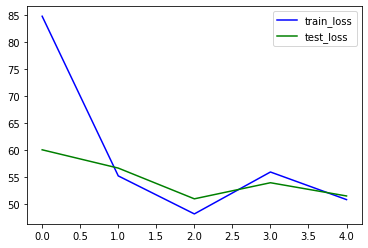

In [ ]:
########### for debug ##############
hidden_size = 128
lang = prepareData()

encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

encoder, decoder = trainIters(lang, encoder1, attn_decoder1, 75000, print_every=1000)